# Case Ifood

## Modelagem

Utiliza duas abordagens: 
* Supervisionada (Random Forest e Regressão Logística) 
  - Prever a probabilidade de conversão de um cliente ao receber um cupom.
* Não Supervisionada (KMeans) 
  - Alternativamente, segmentar os clientes em perfis de comportamento semelhantes (clusterização) para ações direcionadas.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
#from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Importar bibliotecas e configurar Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("iFoodCase").getOrCreate()


### Carregamento do dataset processado

In [ ]:
df_spark = spark.read.parquet("dbfs:/FileStore/tables/final_dataset.parquet") # para ler local use '../data/processed/final_dataset.parquet'
df = df_spark.toPandas()

# Filtra apenas os eventos relacionados a ofertas para modelagem supervisionada
#df = df[df['event'].isin(['offer received'])]

In [ ]:
df.dtypes

age                                       int32
credit_card_limit                       float64
gender                                   object
registered_on                             int32
account_id                               object
time_since_test_start                     int32
event                                    object
amount                                  float32
reward                                  float32
offer_id2                                object
perc_offers_used                        float64
received_offer_flag                       int32
time_offer_received_completed           float64
converted                                 int32
time_offer_received_completed_filled      int32
was_imputed_time_offer                    int32
count_transactions_by_accountid_30d       int32
sum_amount_by_accountid_30d             float32
sum_reward_by_accountid_30d             float32
discount_value                            int32
duration                                

### Verificação da construção do target binário

In [ ]:
print("Distribuição do target")
print(df['converted'].value_counts(normalize=True))

Distribuição do target
0    0.527836
1    0.472164
Name: converted, dtype: float64


### Modelos supervisionados

In [ ]:
print("---- Caminho A: Modelos Supervisionados ----")

# 3.1 Seleção de variáveis
features = ['age','credit_card_limit','count_transactions_by_accountid_30d','sum_amount_by_accountid_30d','sum_reward_by_accountid_30d','duration','min_value'
            ,'gender_ohe_0','gender_ohe_1','gender_ohe_2','offer_type_ohe_0','offer_type_ohe_1','offer_type_ohe_2','channel_ohe_0','channel_ohe_1','channel_ohe_2','channel_ohe_3']
X = df[features]
y = df['converted']

---- Caminho A: Modelos Supervisionados ----


In [ ]:
# 3.2 Escalonamento e split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
## 3.3 Aplicação do SMOTE apenas no conjunto de treino
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
#print("Distribuição do target após SMOTE (conjunto de treino):")
#print(pd.Series(y_train_resampled).value_counts(normalize=True))

#### Treino e avaliação dos modelos

In [ ]:
# 3.4 Treinamento dos modelos 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
#rf.fit(X_train_resampled, y_train_resampled)
rf_pred = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
#lr.fit(X_train_resampled, y_train_resampled)
lr_pred = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:, 1]

#### Métricas + análise de erro

In [ ]:
# 4. Avaliação dos Modelos
print("\nRandom Forest Metrics:")
print(classification_report(y_test, rf_pred))
print("AUC:", roc_auc_score(y_test, rf_probs))

print("\nLogistic Regression Metrics:")
print(classification_report(y_test, lr_pred))
print("AUC:", roc_auc_score(y_test, lr_probs))


Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     28375
           1       0.84      0.86      0.85     25383

    accuracy                           0.86     53758
   macro avg       0.86      0.86      0.86     53758
weighted avg       0.86      0.86      0.86     53758

AUC: 0.9411442977288382

Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     28375
           1       0.78      0.77      0.77     25383

    accuracy                           0.79     53758
   macro avg       0.79      0.79      0.79     53758
weighted avg       0.79      0.79      0.79     53758

AUC: 0.8784848286367389


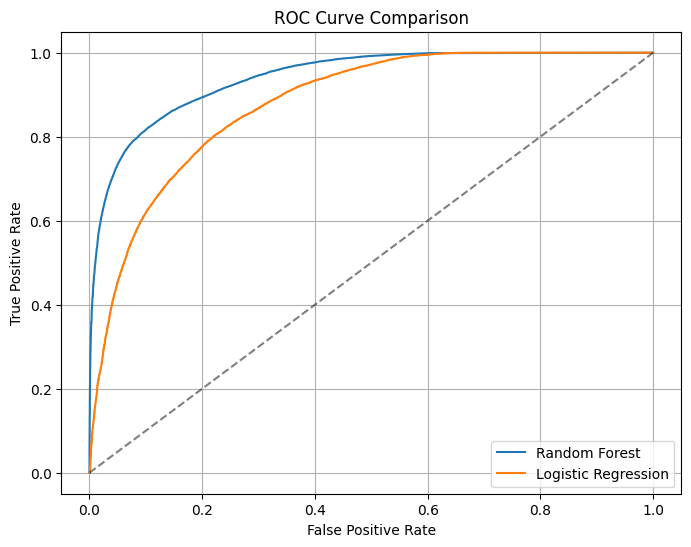

In [ ]:
# 5. Curva ROC Comparativa
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

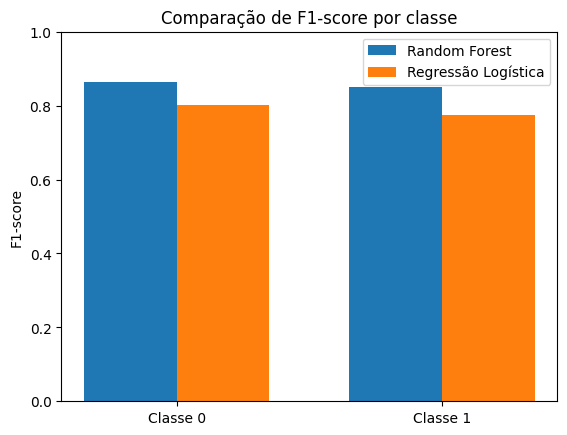

In [ ]:

# Gerar relatórios como dicionários
report_rf = classification_report(y_test, rf_pred, output_dict=True)
report_lr = classification_report(y_test, lr_pred, output_dict=True)

# Extrair F1-score para as classes 0 e 1
f1_rf = [report_rf['0']['f1-score'], report_rf['1']['f1-score']]
f1_lr = [report_lr['0']['f1-score'], report_lr['1']['f1-score']]

classes = ['Classe 0', 'Classe 1']
x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_rf, width, label='Random Forest')
rects2 = ax.bar(x + width/2, f1_lr, width, label='Regressão Logística')

ax.set_ylabel('F1-score')
ax.set_title('Comparação de F1-score por classe')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.ylim(0,1)

plt.show()


### Modelo não supervisionado

In [ ]:
print("---- Caminho B: Clusterização Não Supervisionada ----")

clustering_features = ['age','credit_card_limit','duration','min_value'
                       ,'gender_ohe_0','gender_ohe_1','gender_ohe_2','offer_type_ohe_0','offer_type_ohe_1','offer_type_ohe_2','channel_ohe_0','channel_ohe_1','channel_ohe_2','channel_ohe_3']
X_cluster = df[clustering_features]#.dropna()


---- Caminho B: Clusterização Não Supervisionada ----


In [ ]:
X_cluster

,age,credit_card_limit,duration,min_value,gender_ohe_0,gender_ohe_1,gender_ohe_2,offer_type_ohe_0,offer_type_ohe_1,offer_type_ohe_2,channel_ohe_0,channel_ohe_1,channel_ohe_2,channel_ohe_3
0,45,42000.0,5,10,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,45,42000.0,5,10,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,45,42000.0,5,10,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,45,42000.0,5,10,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,45,42000.0,5,5,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268781,79,103000.0,7,5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
268782,118,57400.0,7,7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
268783,118,57400.0,7,7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
268784,118,57400.0,7,7,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
scaler = MinMaxScaler()#StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

#### Criação dos clusters

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
df['cluster_id'] = kmeans.fit_predict(X_scaled)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa067b828c0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/databricks/python/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_ca

#### Caracterização dos grupos

In [ ]:
# Amostragem dos dados e labels (10%)
sample_frac = 0.1
random_state = 42

np.random.seed(random_state)
sample_indices = np.random.choice(len(X_scaled), size=int(len(X_scaled) * sample_frac), replace=False)

sample_features = X_scaled[sample_indices]
sample_labels = df['cluster_id'].iloc[sample_indices]

# Calcular Silhouette Score com amostra
sil_score = silhouette_score(sample_features, sample_labels)
print(f"Silhouette Score (amostra {sample_frac*100:.0f}%): {sil_score:.4f}")


Silhouette Score (amostra 10%): 0.3413


In [ ]:
cluster_summary = df.groupby('cluster_id')[clustering_features].mean().round(2)
display(cluster_summary)

age,credit_card_limit,duration,min_value,gender_ohe_0,gender_ohe_1,gender_ohe_2,offer_type_ohe_0,offer_type_ohe_1,offer_type_ohe_2,channel_ohe_0,channel_ohe_1,channel_ohe_2,channel_ohe_3
72.9,72759.62,3.49,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.33,0.33,0.16,0.17
73.0,72921.46,5.85,7.5,0.0,1.0,0.0,1.0,0.0,0.0,0.29,0.29,0.21,0.21
52.14,61094.13,8.38,10.54,0.98,0.0,0.02,0.0,1.0,0.0,0.31,0.23,0.31,0.16
52.15,61037.33,5.86,7.51,0.98,0.0,0.02,1.0,0.0,0.0,0.29,0.29,0.21,0.22
72.73,72719.12,8.38,10.56,0.0,1.0,0.0,0.0,1.0,0.0,0.31,0.23,0.31,0.16
52.45,61050.54,3.5,0.0,0.98,0.0,0.02,0.0,0.0,1.0,0.33,0.33,0.17,0.17


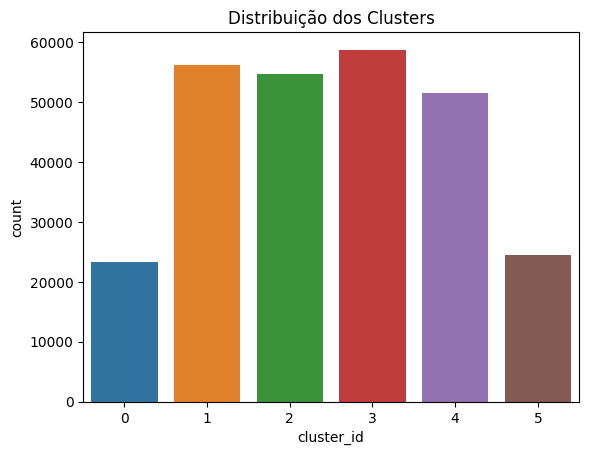

In [ ]:
sns.countplot(x='cluster_id', data=df)
plt.title("Distribuição dos Clusters")
plt.show()

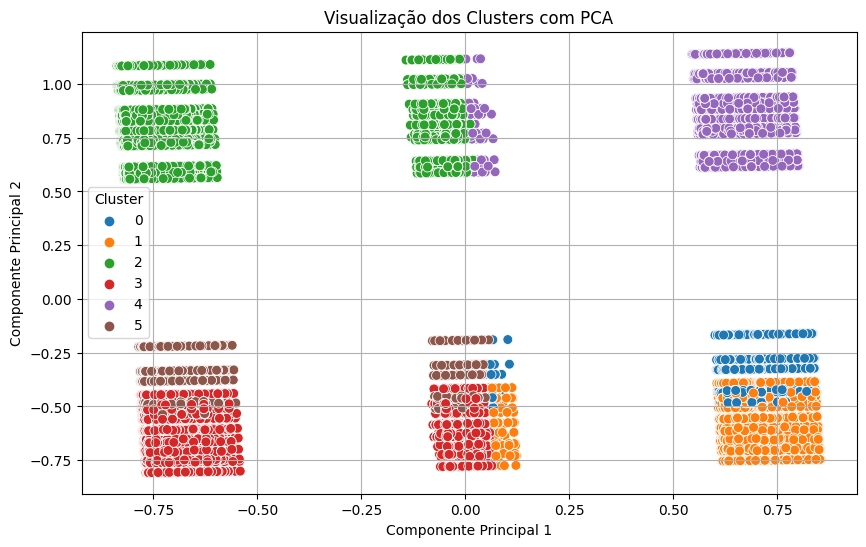

In [ ]:
# PCA para redução de dimensionalidade
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Criar DataFrame com componentes principais e clusters
df_viz = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_viz["cluster"] = df["cluster_id"].values

# Visualizar
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x="PC1", y="PC2", hue="cluster", palette="tab10", s=50)
plt.title("Visualização dos Clusters com PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()
